# Overview

This is my work for the Disaster Tweets NLP Kaggle challenge.

I really enjoyed this challenge where I tackled it using different methods like Recurrent Neural Networks, and Transformers.
I got the best score from the BERTweet model used with a head of a Dense layer with 32 units and an output layer, with an F1 Score of 0.83634.

For the data preprocessing I got inspired by these notebooks:
 - https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
 - https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

In this notebook you will find the data preprocessing, EDA, and modeling using LSTMs, BERT, RoBERTa, ConvBERT, and BERTweet.

Each cell is commented, but if you have any questions please contact me.

Thank you for your time and have fun :)

# Imports

In [1]:
#Add the nlp-getting-started.zip data file to the environment

In [2]:
#Unzipping data file
!unzip "nlp-getting-started.zip"

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
#Installing transformers
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 3.3 MB 23.3 MB/s 
     |████████████████████████████████| 895 kB 42.5 MB/s 
     |████████████████████████████████| 596 kB 50.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import gc
import re
import string
import operator
from collections import defaultdict
import nltk
nltk.download('punkt')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns

import wordcloud

from wordcloud import STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from collections import Counter

from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

import random

import tensorflow as tf

import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, RobertaTokenizerFast, RobertaForSequenceClassification, ConvBertTokenizerFast, ConvBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

SEED = 1337

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#Setting the seed
def set_seed(seed: int):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [6]:
set_seed(SEED)

# Reading Data

In [7]:
#Reading train set
df_train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
#Reading test set
df_test = pd.read_csv('test.csv', dtype={'id': np.int16})
#Reading sample submission
sub = pd.read_csv("sample_submission.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


In [8]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# EDA and Data Preprocessing

In [9]:
def visualize(df, attribute):
    '''
      Function used to visualize the number of tweets per attribute
    '''
    groups = df.groupby(attribute)
    counts = groups.size()

    figure(figsize=(10, 6), dpi=80)
    counts.plot(kind='bar')
    plt.xlabel(attribute)
    plt.ylabel('Number of Tweets')
    plt.title('Number of Tweets per '+attribute)

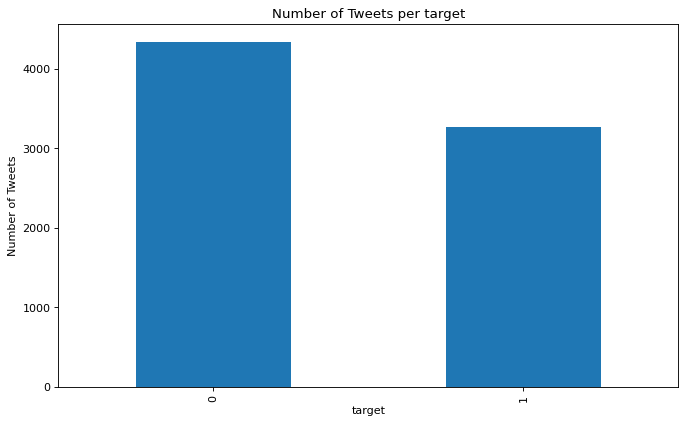

In [10]:
#Visualize number of tweets per target: Number of Non-Disaster tweets vs Disaster tweets in our train set
visualize(df_train, "target")

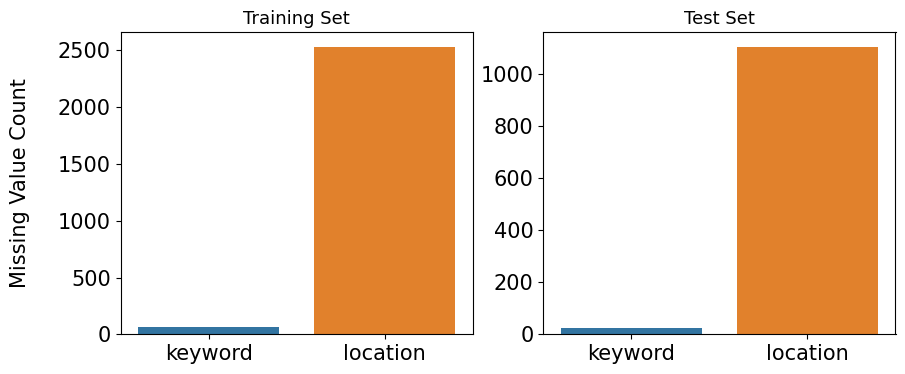

In [11]:
#Visualize missing values for location and keyword in train and testset
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

#Replacing na values with "no_{col}"
for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

**Adding metadata**

In [12]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

**EDA with metadata**

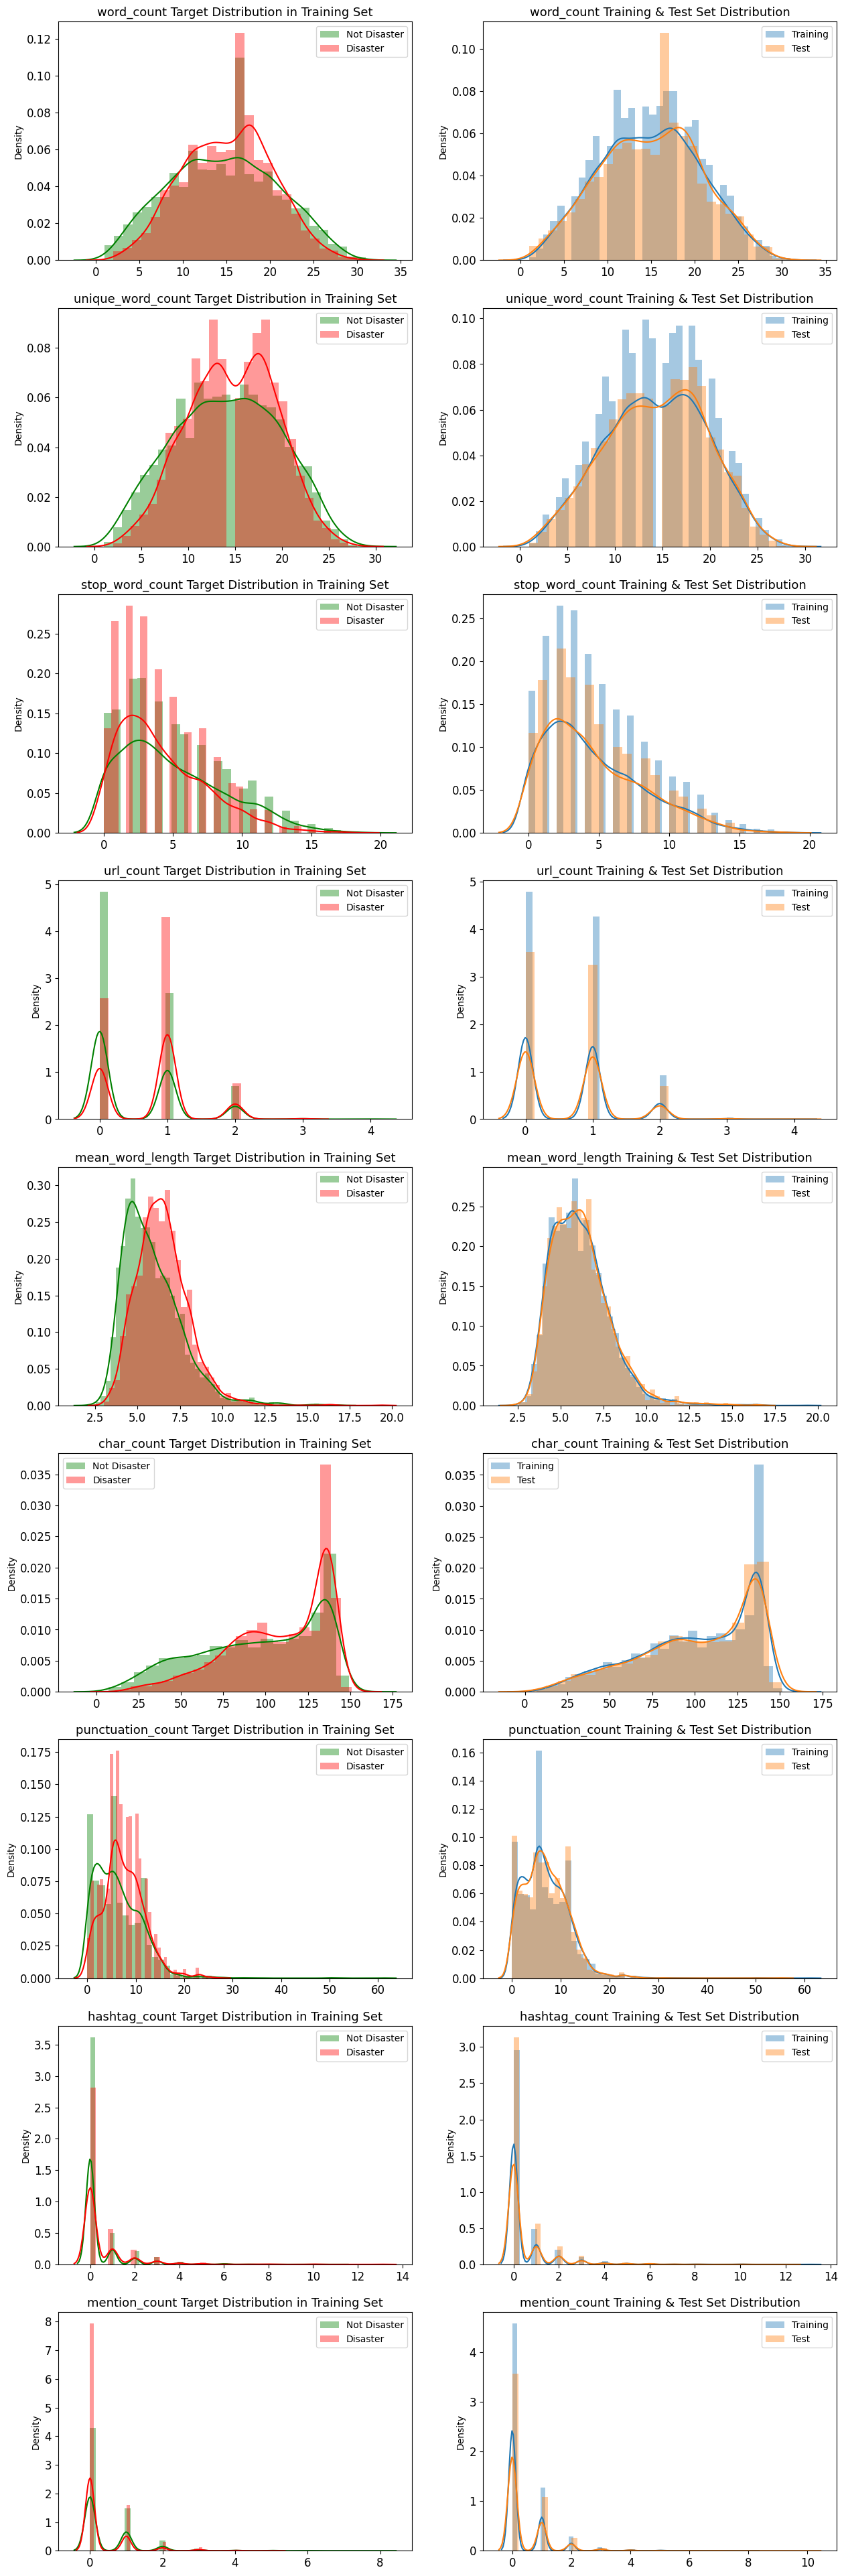

In [13]:
import warnings
warnings.filterwarnings('ignore')

#Visualize Metafeatures per target (Disaster vs Non-Disaster) and per set ( train vs test )
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(15, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

**Stop words EDA**

In [14]:
def create_corpus(target):
    '''
      Returns text of the passed target ( 0 or 1 )
    '''
    corpus=[]
    
    for x in df_train[df_train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Stop words in Non Disaster Tweets

In [15]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

<BarContainer object of 10 artists>

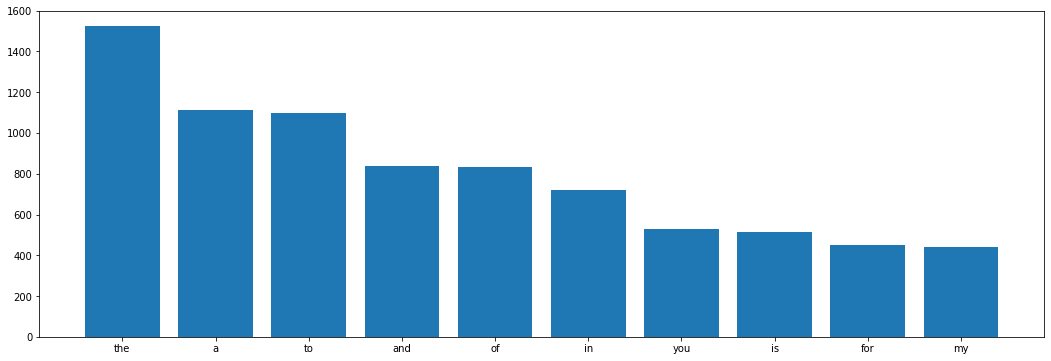

In [16]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

Stop words in Disaster Tweets

<BarContainer object of 10 artists>

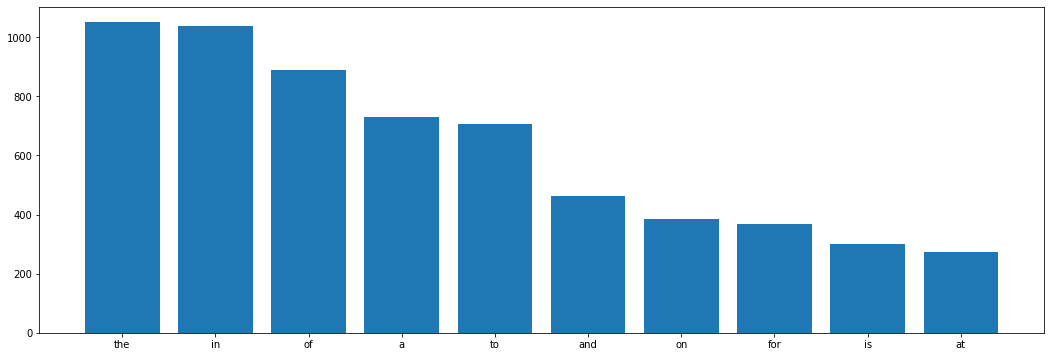

In [17]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

**Punctuation EDA**

Punctuation in Non Disaster Tweets

<BarContainer object of 18 artists>

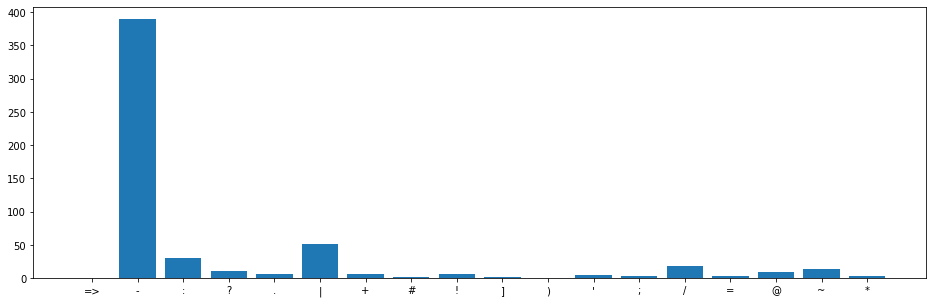

In [18]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

Punctuation in Disaster Tweets

<BarContainer object of 20 artists>

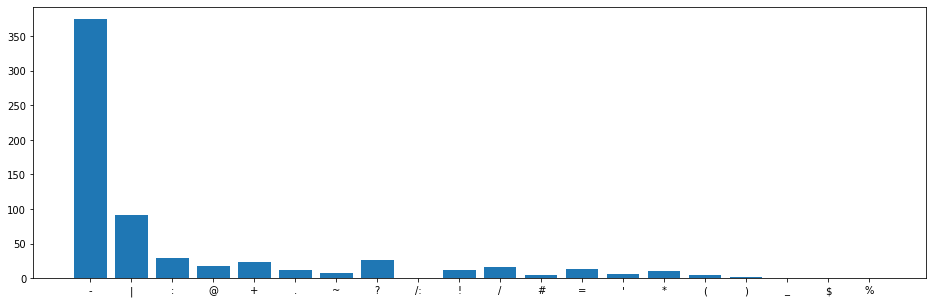

In [19]:
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

**Common words EDA**

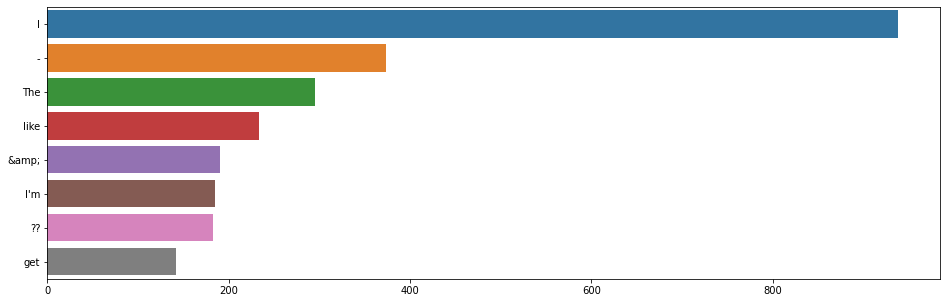

In [20]:
plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

**Bigram Analysis**

In [21]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

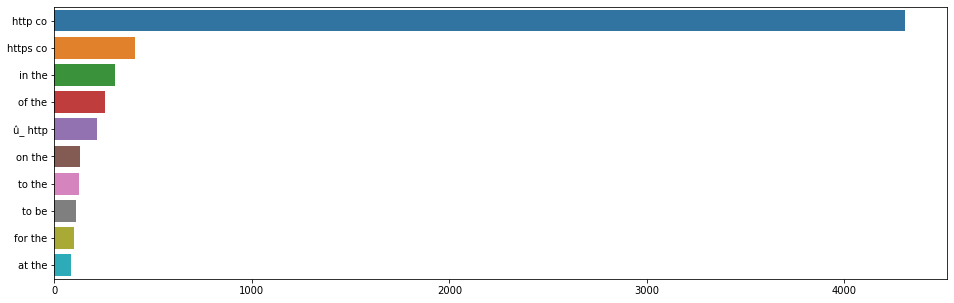

In [22]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(df_train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

**Data Cleaning**

Removing URLs

In [23]:
#Removing URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [24]:
#Removing URLs from train set
df_train['text']=df_train['text'].apply(lambda x : remove_URL(x))
#Removing URLs from test set
df_test['text']=df_test['text'].apply(lambda x : remove_URL(x))

Removing HTML Tags

In [25]:
#Removing HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [26]:
#Removing HTML Tags from train set
df_train['text']=df_train['text'].apply(lambda x : remove_html(x))
#Removing HTML Tags from test set
df_test['text']=df_test['text'].apply(lambda x : remove_html(x))

Removing Emojis

In [27]:
#Removing Emojis
#Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [28]:
#Removing Emojis from train set
df_train['text']=df_train['text'].apply(lambda x : remove_emoji(x))
#Removing Emojis from test set
df_test['text']=df_test['text'].apply(lambda x : remove_emoji(x))

Removing punctuations

In [29]:
#Removing punctuation
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [30]:
#Removing punctuation from train set
df_train['text']=df_train['text'].apply(lambda x : remove_punct(x))
#Removing punctuation from test set
df_test['text']=df_test['text'].apply(lambda x : remove_punct(x))

Cleaning from special characters, Contractions, entity references, Typos, slang, informal abbreviations, hashtags, usernames and Acronyms

Replacing abreviations

In [31]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that  right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [32]:
#Convert abbreviations in each word
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word
#Convert abbreviations in each tweet
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [33]:
#Converting abbreviations in train set
df_train['text'] = df_train['text'].apply(lambda s : convert_abbrev_in_text(s))
#Converting abbreviations in test set
df_test['text'] = df_test['text'].apply(lambda s : convert_abbrev_in_text(s))

Wordcloud on preprocessed data

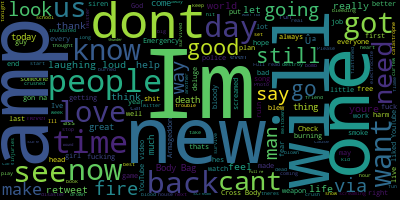

In [34]:
#Most used words in Non-Disaster tweets
long_string = " ".join(df_train[df_train["target"]==0].text)
_wordcloud = wordcloud.WordCloud()
_wordcloud.generate(long_string)
_wordcloud.to_image()

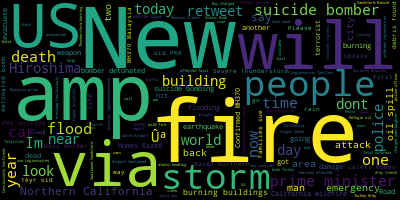

In [35]:
#Most used words in Disaster tweets
long_string = " ".join(df_train[df_train["target"]==1].text)
_wordcloud = wordcloud.WordCloud()
_wordcloud.generate(long_string)
_wordcloud.to_image()

In [36]:
df_train.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,no_keyword,no_location,Our Deeds are the Reason of this earthquake Ma...,1,13,13,6,0,4.384615,69,1,1,0
1,4,no_keyword,no_location,Forest fire near La Ronge Sask Canada,1,7,7,0,0,4.571429,38,1,0,0
2,5,no_keyword,no_location,All residents asked to shelter in place are be...,1,22,20,11,0,5.090909,133,3,0,0
3,6,no_keyword,no_location,13000 people receive wildfires evacuation orde...,1,8,8,1,0,7.125000,65,2,1,0
4,7,no_keyword,no_location,Just got sent this photo from Ruby Alaska as s...,1,16,15,7,0,4.500000,88,2,2,0


# Modeling

In [37]:
#Train test split
(train_texts, valid_texts, train_labels, valid_labels) = train_test_split(list(df_train["text"]), list(df_train["target"]), test_size=0.1, random_state=42)

## **Recurrent Neural Networks: LSTM**

*F1 Score: 0.76923*

In [38]:
#Parameters
max_words = 10000
max_len = 256
epochs = 6
batch_size = 5

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
#Training tokenizer on text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

In [41]:
# Tokenize and pad data
sequences = tokenizer.texts_to_sequences(df_train["text"])
x = pad_sequences(sequences, maxlen=max_len)

In [42]:
#Split tokenized data
x_train, x_valid, y_train, y_valid = train_test_split(x,
                                                    df_train["target"],
                                                    train_size=0.9,
                                                    random_state=42,
                                                    )

In [43]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

In [44]:
#Creating our model architecture
model = Sequential()
model.add(Embedding(max_words, 12, input_length=max_len))
model.add(LSTM(6))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy')

In [45]:
#Callback to save model checkpoints
checkpoint_callback_lstm = ModelCheckpoint('./results/lstm',
                                                   monitor='val_accuracy',
                                                   save_best_only=True,
                                                   verbose=1)

In [46]:
 #Training the model
 history_lstm = model.fit((x_train),
                                 np.array(train_labels),
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_data=(x_valid, np.array(valid_labels)),
                                 callbacks=[checkpoint_callback_lstm])

Epoch 1/6
1371/1371 [==============================] - 58s 37ms/step - loss: 0.5726 - accuracy: 0.7141 - val_loss: 0.4644 - val_accuracy: 0.7900

Epoch 00001: val_accuracy improved from -inf to 0.79003, saving model to ./results/lstm


INFO:tensorflow:Assets written to: ./results/lstm/assets


INFO:tensorflow:Assets written to: ./results/lstm/assets


Epoch 2/6
1371/1371 [==============================] - 51s 37ms/step - loss: 0.4080 - accuracy: 0.8445 - val_loss: 0.4799 - val_accuracy: 0.7717

Epoch 00002: val_accuracy did not improve from 0.79003
Epoch 3/6
1371/1371 [==============================] - 51s 37ms/step - loss: 0.3177 - accuracy: 0.8824 - val_loss: 0.5141 - val_accuracy: 0.7795

Epoch 00003: val_accuracy did not improve from 0.79003
Epoch 4/6
1371/1371 [==============================] - 51s 37ms/step - loss: 0.2692 - accuracy: 0.9069 - val_loss: 0.5759 - val_accuracy: 0.7690

Epoch 00004: val_accuracy did not improve from 0.79003
Epoch 5/6
1371/1371 [==============================] - 51s 37ms/step - loss: 0.2359 - accuracy: 0.9168 - val_loss: 0.6077 - val_accuracy: 0.7651

Epoch 00005: val_accuracy did not improve from 0.79003
Epoch 6/6
1371/1371 [==============================] - 51s 37ms/step - loss: 0.2028 - accuracy: 0.9307 - val_loss: 0.6706 - val_accuracy: 0.7625

Epoch 00006: val_accuracy did not improve from 0.7

LSTM Inference

In [47]:
def get_prediction_lstm(input_text):
    '''
      Function that tokenizes input_text and predicts its class
    '''
    text_sequences = tokenizer.texts_to_sequences([input_text])
    text_sequences = pad_sequences(text_sequences, maxlen=max_len)
    result = model.predict(text_sequences)
    return np.where(result > 0.5, 1, 0)

In [48]:
#Example prediction
text = """
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
"""
print(get_prediction_lstm(text))

[[1]]


In [49]:
# Inference LSTM
for index, row in tqdm(df_test.iterrows()):
    pred = get_prediction_lstm(df_test.iloc[index].text)
    sub.iloc[index].target = pred

3263it [03:28, 15.62it/s]


In [50]:
#Check distribution of predictions
sub.groupby("target").count()

,id
target,
0,2062
1,1201


Save the results

In [51]:
sub.to_csv("sub_lstm.csv", index=False)

## **Transfomers**

In [52]:
#Dataset class for the tweets
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [53]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  '''
    Function to compute accuracy
  '''
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [54]:
def get_prediction(text):
    '''
      Function that tokenizes text and predicts its class
    '''
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return probs.argmax()

**Transformers BERT**

*F1 Score: 0.81734*

In [55]:
# Pretrained model
model_name = "bert-base-uncased"
# Max sequence length 
max_length = 128

In [56]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

DEBUG:filelock:Attempting to acquire lock 140430805929680 on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
DEBUG:filelock:Lock 140430805929680 acquired on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140430805929680 on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
DEBUG:filelock:Lock 140430805929680 released on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
DEBUG:filelock:Attempting to acquire lock 140433356360336 on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
DEBUG:filelock:Lock 140433356360336 acquired on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140433356360336 on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
DEBUG:filelock:Lock 140433356360336 released on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
DEBUG:filelock:Attempting to acquire lock 140433511619600 on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
DEBUG:filelock:Lock 140433511619600 acquired on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140433511619600 on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
DEBUG:filelock:Lock 140433511619600 released on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
DEBUG:filelock:Attempting to acquire lock 140433521662864 on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock
DEBUG:filelock:Lock 140433521662864 acquired on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140433521662864 on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock
DEBUG:filelock:Lock 140433521662864 released on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock


In [57]:
# Tokenize the dataset, truncate when passed `max_length`, 
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [58]:
# Convert our tokenized data into a torch Dataset
train_dataset = TweetDataset(train_encodings, train_labels)
valid_dataset = TweetDataset(valid_encodings, valid_labels)

In [59]:
#Load pretrained model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to("cuda")

DEBUG:filelock:Attempting to acquire lock 140431477178704 on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock
DEBUG:filelock:Lock 140431477178704 acquired on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140431477178704 on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock
DEBUG:filelock:Lock 140431477178704 released on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or wi

In [60]:
#Training arguments
training_args = TrainingArguments(
    output_dir='./results/bert',     # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training
    logging_steps=500,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [61]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [62]:
# Train the model
trainer.train()

***** Running training *****
  Num examples = 6851
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1287


Step,Training Loss,Validation Loss,Accuracy
500,0.469000,0.445109,0.803150
1000,0.336300,0.495550,0.830709


***** Running Evaluation *****
  Num examples = 762
  Batch size = 20
Saving model checkpoint to ./results/bert/checkpoint-500
Configuration saved in ./results/bert/checkpoint-500/config.json
Model weights saved in ./results/bert/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 762
  Batch size = 20
Saving model checkpoint to ./results/bert/checkpoint-1000
Configuration saved in ./results/bert/checkpoint-1000/config.json
Model weights saved in ./results/bert/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/bert/checkpoint-500 (score: 0.44510889053344727).


TrainOutput(global_step=1287, training_loss=0.35968402901081126, metrics={'train_runtime': 498.6847, 'train_samples_per_second': 41.214, 'train_steps_per_second': 2.581, 'total_flos': 580907585243700.0, 'train_loss': 0.35968402901081126, 'epoch': 3.0})

In [63]:
# Evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 762
  Batch size = 20


{'epoch': 3.0,
 'eval_accuracy': 0.8031496062992126,
 'eval_loss': 0.44510889053344727,
 'eval_runtime': 4.4833,
 'eval_samples_per_second': 169.963,
 'eval_steps_per_second': 8.699}

Inference BERT

In [64]:
#Example prediction
text = """
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
"""
print(get_prediction(text))

tensor(1, device='cuda:0')


In [65]:
# Inference BERT
for index, row in tqdm(df_test.iterrows()):
  pred = get_prediction(df_test.iloc[index].text)
  sub.iloc[index].target = pred

3263it [01:03, 51.13it/s]


In [66]:
#Check distribution of predictions
sub.groupby("target").count()

,id
target,
0,1922
1,1341


Save the results

In [67]:
sub.to_csv("sub_bert.csv", index=False)

**RoBERTa**

*F1 Score: 0.82960*

In [68]:
# Pretrained model
model_name = "roberta-base"
# Max sequence length 
max_length = 128

In [69]:
# Load the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained(model_name, do_lower_case=True)

DEBUG:filelock:Attempting to acquire lock 140433527035728 on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
DEBUG:filelock:Lock 140433527035728 acquired on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
https://huggingface.co/roberta-base/resolve/main/vocab.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4t9hnjz9


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
DEBUG:filelock:Attempting to release lock 140433527035728 on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
DEBUG:filelock:Lock 140433527035728 released on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
DEBUG:filelock:Attempting to acquire lock 140433511546000 on /root/.cache/huggingface/transformers/caf

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
DEBUG:filelock:Attempting to release lock 140433511546000 on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
DEBUG:filelock:Lock 140433511546000 released on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
DEBUG:filelock:Attempting to acquire lock 140430805570448 on /root/.cache/huggingface/transformers/d53

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
DEBUG:filelock:Attempting to release lock 140430805570448 on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
DEBUG:filelock:Lock 140430805570448 released on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cach

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
creating metadata file for /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
DEBUG:filelock:Attempting to release lock 140430794572496 on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
DEBUG:filelock:Lock 140430794572496 released on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at

In [70]:
# Tokenize the dataset, truncate when passed `max_length`, 
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [71]:
# Convert our tokenized data into a torch Dataset
train_dataset = TweetDataset(train_encodings, train_labels)
valid_dataset = TweetDataset(valid_encodings, valid_labels)

In [72]:
#Load model
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2).to("cuda")

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

DEBUG:filelock:Attempting to acquire lock 140433530571024 on /root/.cache/huggingface/transfo

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
creating metadata file for /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
DEBUG:filelock:Attempting to release lock 140433530571024 on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
DEBUG:filelock:Lock 140433530571024 released on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from ca

In [73]:
#Training arguments
training_args = TrainingArguments(
    output_dir='./results/roberta',     # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    logging_steps=500,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [74]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [75]:
# Train the model
trainer.train()

***** Running training *****
  Num examples = 6851
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1287


Step,Training Loss,Validation Loss,Accuracy
500,0.487400,0.518413,0.786089
1000,0.393000,0.440352,0.828084


***** Running Evaluation *****
  Num examples = 762
  Batch size = 20
Saving model checkpoint to ./results/roberta/checkpoint-500
Configuration saved in ./results/roberta/checkpoint-500/config.json
Model weights saved in ./results/roberta/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 762
  Batch size = 20
Saving model checkpoint to ./results/roberta/checkpoint-1000
Configuration saved in ./results/roberta/checkpoint-1000/config.json
Model weights saved in ./results/roberta/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/roberta/checkpoint-1000 (score: 0.44035160541534424).


TrainOutput(global_step=1287, training_loss=0.4048716997859454, metrics={'train_runtime': 514.5584, 'train_samples_per_second': 39.943, 'train_steps_per_second': 2.501, 'total_flos': 580907585243700.0, 'train_loss': 0.4048716997859454, 'epoch': 3.0})

In [76]:
# Evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 762
  Batch size = 20


{'epoch': 3.0,
 'eval_accuracy': 0.8280839895013123,
 'eval_loss': 0.44035160541534424,
 'eval_runtime': 4.8714,
 'eval_samples_per_second': 156.424,
 'eval_steps_per_second': 8.006}

Inference RoBERTa

In [77]:
#Example prediction
text = """
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
"""
print(get_prediction(text))

tensor(1, device='cuda:0')


In [78]:
# Inference RoBERTa
for index, row in tqdm(df_test.iterrows()):
  pred = get_prediction(df_test.iloc[index].text)
  sub.iloc[index].target = pred

3263it [01:04, 50.81it/s]


In [79]:
#Check distribution of predictions
sub.groupby("target").count()

,id
target,
0,1957
1,1306


Save the results

In [80]:
sub.to_csv("sub_roberta.csv", index=False)

**ConvBERT**

*F1 Score: 0.81182*

In [81]:
# Pretrained model
model_name = "YituTech/conv-bert-base"
# Max sequence length 
max_length = 512

In [82]:
# Load the tokenizer
tokenizer = ConvBertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

DEBUG:filelock:Attempting to acquire lock 140433536622480 on /root/.cache/huggingface/transformers/75608c7373c277fa55de32e1bd71af40f547910ef3a49ed431d3a9fb9b4f5c8c.16ff552dabca3af1d1d07bc63a184047eb39f686be4a6738ba0167c6b1bb0b84.lock
DEBUG:filelock:Lock 140433536622480 acquired on /root/.cache/huggingface/transformers/75608c7373c277fa55de32e1bd71af40f547910ef3a49ed431d3a9fb9b4f5c8c.16ff552dabca3af1d1d07bc63a184047eb39f686be4a6738ba0167c6b1bb0b84.lock
https://huggingface.co/YituTech/conv-bert-base/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpbllc0ark


Downloading:   0%|          | 0.00/260k [00:00<?, ?B/s]

storing https://huggingface.co/YituTech/conv-bert-base/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/75608c7373c277fa55de32e1bd71af40f547910ef3a49ed431d3a9fb9b4f5c8c.16ff552dabca3af1d1d07bc63a184047eb39f686be4a6738ba0167c6b1bb0b84
creating metadata file for /root/.cache/huggingface/transformers/75608c7373c277fa55de32e1bd71af40f547910ef3a49ed431d3a9fb9b4f5c8c.16ff552dabca3af1d1d07bc63a184047eb39f686be4a6738ba0167c6b1bb0b84
DEBUG:filelock:Attempting to release lock 140433536622480 on /root/.cache/huggingface/transformers/75608c7373c277fa55de32e1bd71af40f547910ef3a49ed431d3a9fb9b4f5c8c.16ff552dabca3af1d1d07bc63a184047eb39f686be4a6738ba0167c6b1bb0b84.lock
DEBUG:filelock:Lock 140433536622480 released on /root/.cache/huggingface/transformers/75608c7373c277fa55de32e1bd71af40f547910ef3a49ed431d3a9fb9b4f5c8c.16ff552dabca3af1d1d07bc63a184047eb39f686be4a6738ba0167c6b1bb0b84.lock
loading file https://huggingface.co/YituTech/conv-bert-base/resolve/main/vocab.txt from cach

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

storing https://huggingface.co/YituTech/conv-bert-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/7651fc6ae3906f28c62923bc7c76b0436327540c1ebb62a60b454ec79e102dd1.2a398d65585c12446cf5e632a1839e1754dc16cbbf6b87ccf28ba24c8536394e
creating metadata file for /root/.cache/huggingface/transformers/7651fc6ae3906f28c62923bc7c76b0436327540c1ebb62a60b454ec79e102dd1.2a398d65585c12446cf5e632a1839e1754dc16cbbf6b87ccf28ba24c8536394e
DEBUG:filelock:Attempting to release lock 140433527783504 on /root/.cache/huggingface/transformers/7651fc6ae3906f28c62923bc7c76b0436327540c1ebb62a60b454ec79e102dd1.2a398d65585c12446cf5e632a1839e1754dc16cbbf6b87ccf28ba24c8536394e.lock
DEBUG:filelock:Lock 140433527783504 released on /root/.cache/huggingface/transformers/7651fc6ae3906f28c62923bc7c76b0436327540c1ebb62a60b454ec79e102dd1.2a398d65585c12446cf5e632a1839e1754dc16cbbf6b87ccf28ba24c8536394e.lock
loading configuration file https://huggingface.co/YituTech/conv-bert-base/resolve/main/con

In [83]:
# Tokenize the dataset, truncate when passed `max_length`, 
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [84]:
# Convert our tokenized data into a torch Dataset
train_dataset = TweetDataset(train_encodings, train_labels)
valid_dataset = TweetDataset(valid_encodings, valid_labels)

In [85]:
# Load model
model = ConvBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to("cuda")

loading configuration file https://huggingface.co/YituTech/conv-bert-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7651fc6ae3906f28c62923bc7c76b0436327540c1ebb62a60b454ec79e102dd1.2a398d65585c12446cf5e632a1839e1754dc16cbbf6b87ccf28ba24c8536394e
Model config ConvBertConfig {
  "_name_or_path": "/home/abhishek/convbert_models/conv-bert-base/",
  "architectures": [
    "ConvBertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "conv_kernel_size": 9,
  "embedding_size": 768,
  "eos_token_id": 2,
  "head_ratio": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "convbert",
  "num_attention_heads": 12,
  "num_groups": 1,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "vocab_size":

Downloading:   0%|          | 0.00/403M [00:00<?, ?B/s]

storing https://huggingface.co/YituTech/conv-bert-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/f71042767b7bb431c7632b9f245661cd34a5edaac1eaf25f3a9e78a73bb711b2.3ee89f2fd82df871ab2d6f643874ee269c534627432695a69f22271e9d077426
creating metadata file for /root/.cache/huggingface/transformers/f71042767b7bb431c7632b9f245661cd34a5edaac1eaf25f3a9e78a73bb711b2.3ee89f2fd82df871ab2d6f643874ee269c534627432695a69f22271e9d077426
DEBUG:filelock:Attempting to release lock 140433527888784 on /root/.cache/huggingface/transformers/f71042767b7bb431c7632b9f245661cd34a5edaac1eaf25f3a9e78a73bb711b2.3ee89f2fd82df871ab2d6f643874ee269c534627432695a69f22271e9d077426.lock
DEBUG:filelock:Lock 140433527888784 released on /root/.cache/huggingface/transformers/f71042767b7bb431c7632b9f245661cd34a5edaac1eaf25f3a9e78a73bb711b2.3ee89f2fd82df871ab2d6f643874ee269c534627432695a69f22271e9d077426.lock
loading weights file https://huggingface.co/YituTech/conv-bert-base/resolve/main/pyt

In [86]:
#Training arguments
training_args = TrainingArguments(
    output_dir='./results/convbert',     # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=500,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [87]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [88]:
# Train the model
trainer.train()

***** Running training *****
  Num examples = 6851
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1287


Step,Training Loss,Validation Loss,Accuracy
500,0.486000,0.439858,0.820210
1000,0.368700,0.483937,0.817585


***** Running Evaluation *****
  Num examples = 762
  Batch size = 20
Saving model checkpoint to ./results/convbert/checkpoint-500
Configuration saved in ./results/convbert/checkpoint-500/config.json
Model weights saved in ./results/convbert/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 762
  Batch size = 20
Saving model checkpoint to ./results/convbert/checkpoint-1000
Configuration saved in ./results/convbert/checkpoint-1000/config.json
Model weights saved in ./results/convbert/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/convbert/checkpoint-500 (score: 0.4398579001426697).


TrainOutput(global_step=1287, training_loss=0.39355041337920976, metrics={'train_runtime': 627.1418, 'train_samples_per_second': 32.772, 'train_steps_per_second': 2.052, 'total_flos': 559128141694980.0, 'train_loss': 0.39355041337920976, 'epoch': 3.0})

In [89]:
# Evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 762
  Batch size = 20


{'epoch': 3.0,
 'eval_accuracy': 0.8202099737532809,
 'eval_loss': 0.4398579001426697,
 'eval_runtime': 5.7727,
 'eval_samples_per_second': 132.0,
 'eval_steps_per_second': 6.756}

Inference ConvBERT

In [90]:
#Example prediction
text = """
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
"""
print(get_prediction(text))

tensor(0, device='cuda:0')


In [91]:
# Inference ConvBERT
for index, row in tqdm(df_test.iterrows()):
  pred = get_prediction(df_test.iloc[index].text)
  sub.iloc[index].target = pred

3263it [01:40, 32.61it/s]


In [92]:
#Check distribution of predictions
sub.groupby("target").count()

,id
target,
0,2145
1,1118


Save the results

In [93]:
sub.to_csv("sub_convbert.csv", index=False)

**BERTweet**

*F1 Score: 0.83634*

In [94]:
# Pretrained model
model_name = "vinai/bertweet-base"
# Max sequence length 
max_length = 128

In [95]:
from transformers import AutoTokenizer, TFRobertaModel

In [96]:
#Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          normalization=True, 
                                          use_fast = False,
                                          add_special_tokens=True,
                                          pad_to_max_length=True,
                                          return_attention_mask=True)

Could not locate the tokenizer configuration file, will try to use the model config instead.
DEBUG:filelock:Attempting to acquire lock 140433523109456 on /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d.lock
DEBUG:filelock:Lock 140433523109456 acquired on /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d.lock
https://huggingface.co/vinai/bertweet-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp3pyoi540


Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

storing https://huggingface.co/vinai/bertweet-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
creating metadata file for /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
DEBUG:filelock:Attempting to release lock 140433523109456 on /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d.lock
DEBUG:filelock:Lock 140433523109456 released on /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d.lock
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

storing https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
creating metadata file for /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
DEBUG:filelock:Attempting to release lock 140433516688848 on /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982.lock
DEBUG:filelock:Lock 140433516688848 released on /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982.lock
DEBUG:filelock:Attempting to acquire lock 140433538522320 on /root/.cache/huggingface/transforme

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

storing https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes in cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
creating metadata file for /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
DEBUG:filelock:Attempting to release lock 140433538522320 on /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4.lock
DEBUG:filelock:Lock 140433538522320 released on /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4.lock
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /ro

In [97]:
# Tokenize the dataset, truncate when passed `max_length`, 
train_encodings = tokenizer(train_texts,  padding="max_length",  truncation=True, return_tensors = 'tf').data
valid_encodings = tokenizer(valid_texts,  padding="max_length",  truncation=True, return_tensors = 'tf').data

In [98]:
# Creating the train dataset
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_encodings, train_labels))
train_tf_dataset = train_tf_dataset.shuffle(len(train_texts)).batch(16).prefetch(tf.data.AUTOTUNE)
#Creating the valid dataset
valid_tf_dataset  = tf.data.Dataset.from_tensor_slices((valid_encodings, valid_labels))
valid_tf_dataset  = valid_tf_dataset.shuffle(len(valid_texts)).batch(16).prefetch(tf.data.AUTOTUNE)

In [99]:
# Create model architecture using the pretrained model and adding head layers
bertweet_model = TFRobertaModel.from_pretrained(model_name) 

input_ids = tf.keras.Input(shape=(128,),dtype='int32', name = 'input_ids')
attention_masks = tf.keras.Input(shape=(128,),dtype='int32', name = 'attention_mask')

output = bertweet_model([input_ids,attention_masks])[1]
output = tf.keras.layers.Dense(32,activation='relu')(output)
output = tf.keras.layers.Dropout(0.25)(output)
output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Stopping the pretrained model from training again
model.layers[2].trainable = False

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

DEBUG:fil

Downloading:   0%|          | 0.00/705M [00:00<?, ?B/s]

storing https://huggingface.co/vinai/bertweet-base/resolve/main/tf_model.h5 in cache at /root/.cache/huggingface/transformers/13c1b104e371255efe2369b5ef6c49b91976b960e3ce575c356e7e8f122bb553.49cad0185419ad4290fe7429c1f7ca1c37f46047828021f4cf2ed61d7c79c0ec.h5
creating metadata file for /root/.cache/huggingface/transformers/13c1b104e371255efe2369b5ef6c49b91976b960e3ce575c356e7e8f122bb553.49cad0185419ad4290fe7429c1f7ca1c37f46047828021f4cf2ed61d7c79c0ec.h5
DEBUG:filelock:Attempting to release lock 140430746509200 on /root/.cache/huggingface/transformers/13c1b104e371255efe2369b5ef6c49b91976b960e3ce575c356e7e8f122bb553.49cad0185419ad4290fe7429c1f7ca1c37f46047828021f4cf2ed61d7c79c0ec.h5.lock
DEBUG:filelock:Lock 140430746509200 released on /root/.cache/huggingface/transformers/13c1b104e371255efe2369b5ef6c49b91976b960e3ce575c356e7e8f122bb553.49cad0185419ad4290fe7429c1f7ca1c37f46047828021f4cf2ed61d7c79c0ec.h5.lock
loading weights file https://huggingface.co/vinai/bertweet-base/resolve/main/tf_mo

In [100]:
#Train model
history = model.fit(train_tf_dataset,
                    validation_data = valid_tf_dataset,
                    epochs = 2)

Epoch 1/2
429/429 [==============================] - 391s 866ms/step - loss: 0.4674 - accuracy: 0.7921 - val_loss: 0.4349 - val_accuracy: 0.8163
Epoch 2/2
429/429 [==============================] - 368s 858ms/step - loss: 0.3608 - accuracy: 0.8624 - val_loss: 0.4133 - val_accuracy: 0.8320


Inference BERTweet

In [101]:
# Tokenize test texts
test_tokenized = tokenizer(list(df_test['text']), 
                  padding="max_length", 
                  truncation=True,
                  return_tensors = 'tf').data

In [102]:
# Generate predictions from tokenized test texts
preds = model.predict(test_tokenized)

In [103]:
# Create targets from probabilities
sub["target"]= (preds > 0.5).astype(int)

In [104]:
#Check distribution of predictions
sub.groupby("target").count()

,id
target,
0,1926
1,1337


Save the results

In [105]:
sub.to_csv("sub_bertweet.csv", index=False)